https://jovian.ai/aakashns/06b-anime-dcgan



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thunguyenminh
Your Kaggle Key: ··········


  1%|▏         | 5.00M/395M [00:00<00:12, 31.5MB/s]

100%|██████████| 395M/395M [00:04<00:00, 99.1MB/s]


In [ ]:
%mv -r '/content/animefacedataset' '/content/drive/MyDrive/adv_pro/CNN'

In [3]:
import os

DATA_DIR = '/content/drive/MyDrive/adv_pro/CNN/animefacedataset'
print(os.listdir(DATA_DIR))


['images']


In [4]:
print(os.listdir(DATA_DIR+'/images')[:10])

['47726_2014.jpg', '4747_2003.jpg', '49669_2015.jpg', '46771_2014.jpg', '46920_2014.jpg', '50122_2015.jpg', '50717_2015.jpg', '49643_2015.jpg', '48976_2014.jpg', '51116_2015.jpg']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle= True, num_workers=3,pin_memory=True)

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
  return img_tensors*stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax = 64):
  fig, ax = plt.subplots(figsize =(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

In [11]:
show_batch(train_dl)

# Using a GPU

In [12]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  """Move tensor(s) to chosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl,device)

In [15]:
import torch.nn as nn

In [36]:
discriminator = nn.Sequential(
    # in: 3x64x64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 64x32x32
    nn.Conv2d(64,128, kernel_size=4, stride=2, padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace = True),

    # out: 256x8x8
    nn.Conv2d(128,256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256,512, kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 512x4x4

    nn.Conv2d(512,1,kernel_size=4,stride=1, padding =0, bias = False),
    # out: 1x1x1
    nn.Flatten(),
    nn.Sigmoid()
)

In [37]:
discriminator = to_device(discriminator,device)

# Generator Network

In [38]:
latent_size = 128

In [39]:
generator = nn.Sequential(
    # in: lantent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride =1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512x4x4
    
    nn.ConvTranspose2d(512,256, kernel_size=4, stride=2, padding = 1, bias =False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256x8x8

    nn.ConvTranspose2d(256,128, kernel_size=4,stride =2,padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128x16x16

    nn.ConvTranspose2d(128,64, kernel_size=4, stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64x32x32

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    # out: 3x64x64
)

torch.Size([128, 3, 64, 64])


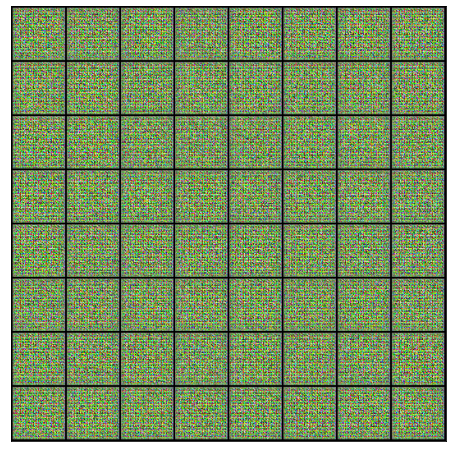

In [40]:
xb = torch.randn(batch_size, latent_size,1,1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [41]:
generator = to_device(generator,device)

#Discriminator Training

In [42]:
def train_discriminator(real_images,opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0),1, device=device)
  real_loss = F.binary_cross_entropy(real_preds,real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size,1,1,device=device)
  fake_images = generator(latent)

  # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0),1,device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

#Generator Training

In [43]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generator fake images
  latent = torch.randn(batch_size, latent_size,1,1,device =device)
  fake_images = generator(latent)

  # Try ti fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size,1, device=device)
  loss = F.binary_cross_entropy(preds,targets)

  # Update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [44]:
from torchvision.utils import save_image

In [45]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

In [46]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir, fake_fname),nrow = 8)
  print('Saving', fake_fname)
  if show:
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(),nrow = 8).permute(1,2,0))

In [47]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


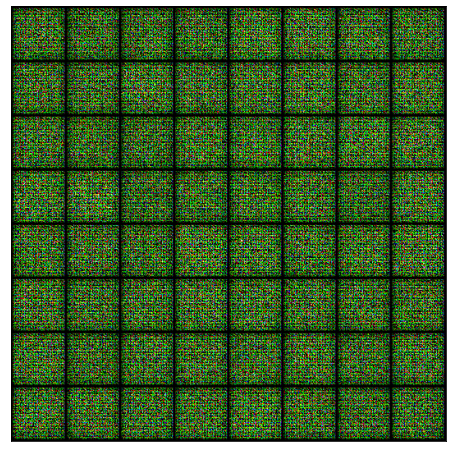

In [48]:
save_samples(0,fixed_latent)

#Full Training Loop

In [49]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [50]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()
  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []
  # Create optimize
  opt_d = torch.optim.Adam(discriminator.parameters(),lr = lr, betas=(0.5,0.999))
  opt_g = torch.optim.Adam(generator.parameters(),lr=lr, betas=(0.5,0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images,opt_d)
      # Train generator
      loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    #Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)
  return losses_g, losses_d, real_scores, fake_scores

In [51]:
lr = 0.0002
epochs = 25

In [52]:
history = fit(epochs, lr)


Epoch [1/25], loss_g: 9.2550, loss_d: 0.0786, real_score: 0.9761, fake_score: 0.0487
Saving generated-images-0001.png



Epoch [2/25], loss_g: 14.6262, loss_d: 0.0244, real_score: 0.9821, fake_score: 0.0000
Saving generated-images-0002.png



Epoch [3/25], loss_g: 15.5280, loss_d: 1.6894, real_score: 0.3477, fake_score: 0.0000
Saving generated-images-0003.png



Epoch [4/25], loss_g: 2.5435, loss_d: 0.6766, real_score: 0.6250, fake_score: 0.0462
Saving generated-images-0004.png



Epoch [5/25], loss_g: 3.3983, loss_d: 0.9695, real_score: 0.6786, fake_score: 0.3110
Saving generated-images-0005.png



Epoch [6/25], loss_g: 4.0963, loss_d: 0.6066, real_score: 0.7549, fake_score: 0.2305
Saving generated-images-0006.png



Epoch [7/25], loss_g: 2.7206, loss_d: 2.3491, real_score: 0.1594, fake_score: 0.0098
Saving generated-images-0007.png



Epoch [8/25], loss_g: 3.0313, loss_d: 0.8007, real_score: 0.7116, fake_score: 0.2983
Saving generated-images-0008.png



Epoch [9/25], loss_g: 3.5834, loss_d: 0.5382, real_score: 0.7066, fake_score: 0.1281
Saving generated-images-0009.png



Epoch [10/25], loss_g: 2.7971, loss_d: 0.5712, real_score: 0.7507, fake_score: 0.1554
Saving generated-images-0010.png



Epoch [11/25], loss_g: 4.5654, loss_d: 1.1304, real_score: 0.7309, fake_score: 0.5178
Saving generated-images-0011.png



Epoch [12/25], loss_g: 2.2921, loss_d: 0.9162, real_score: 0.5431, fake_score: 0.0894
Saving generated-images-0012.png



Epoch [13/25], loss_g: 2.9824, loss_d: 0.5166, real_score: 0.6911, fake_score: 0.0859
Saving generated-images-0013.png



Epoch [14/25], loss_g: 3.5219, loss_d: 0.5213, real_score: 0.7584, fake_score: 0.1817
Saving generated-images-0014.png



Epoch [15/25], loss_g: 1.7944, loss_d: 1.0824, real_score: 0.4458, fake_score: 0.0505
Saving generated-images-0015.png



Epoch [16/25], loss_g: 3.0658, loss_d: 0.7511, real_score: 0.5579, fake_score: 0.0267
Saving generated-images-0016.png



Epoch [17/25], loss_g: 4.4411, loss_d: 0.4346, real_score: 0.9013, fake_score: 0.2609
Saving generated-images-0017.png



Epoch [18/25], loss_g: 4.8726, loss_d: 0.2916, real_score: 0.8721, fake_score: 0.1260
Saving generated-images-0018.png



Epoch [19/25], loss_g: 3.2935, loss_d: 0.4885, real_score: 0.7635, fake_score: 0.1455
Saving generated-images-0019.png



Epoch [20/25], loss_g: 5.1744, loss_d: 1.1638, real_score: 0.3976, fake_score: 0.0045
Saving generated-images-0020.png



Epoch [21/25], loss_g: 4.4057, loss_d: 0.5962, real_score: 0.7839, fake_score: 0.2571
Saving generated-images-0021.png



Epoch [22/25], loss_g: 3.4352, loss_d: 0.5293, real_score: 0.7866, fake_score: 0.2135
Saving generated-images-0022.png



Epoch [23/25], loss_g: 4.9121, loss_d: 0.7223, real_score: 0.8504, fake_score: 0.3855
Saving generated-images-0023.png



Epoch [24/25], loss_g: 2.5565, loss_d: 0.3067, real_score: 0.8645, fake_score: 0.1201
Saving generated-images-0024.png



Epoch [25/25], loss_g: 6.6215, loss_d: 0.8480, real_score: 0.8406, fake_score: 0.4441
Saving generated-images-0025.png


In [53]:
losses_g, losses_d, real_scores, fake_scores = history

In [55]:
# Save the model checkpoint
torch.save(generator.state_dict(),'G.pth')
torch.save(discriminator.state_dict(),'D.pth')

In [56]:
from IPython.display import Image

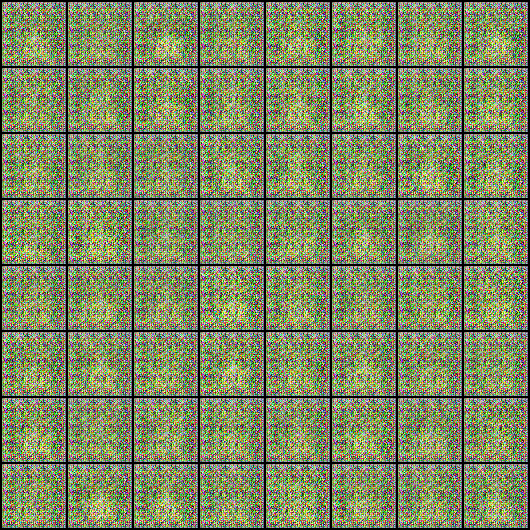

In [57]:
Image('./generated/generated-images-0001.png')

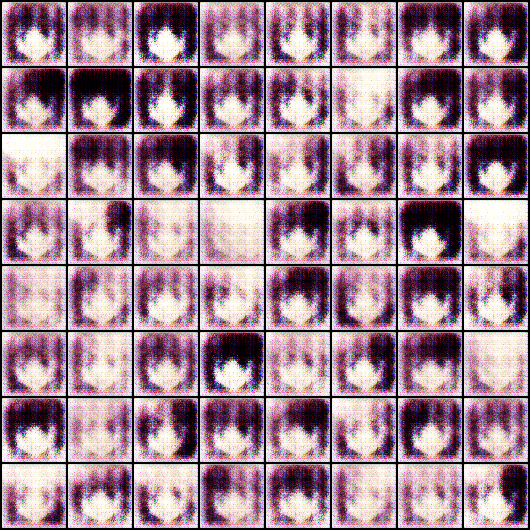

In [58]:
Image('./generated/generated-images-0005.png')

In [59]:
import cv2
import os

vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'),1,(530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Text(0.5, 1.0, 'Losses')

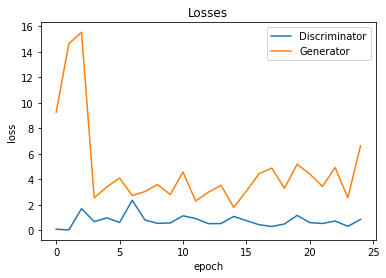

In [60]:
plt.plot(losses_d,'-')
plt.plot(losses_g,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

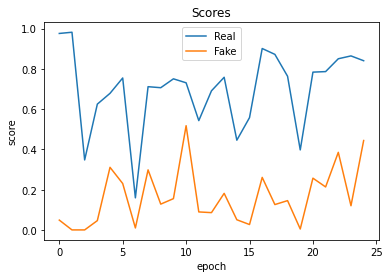

In [61]:
plt.plot(real_scores,'-')
plt.plot(fake_scores,'-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real','Fake'])
plt.title('Scores')